In [34]:
from google.cloud import bigquery
from google.cloud.bigquery import Client, QueryJobConfig, ScalarQueryParameter
from google.cloud import aiplatform as vertexai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit libraries for data preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression

In [7]:
# Retrieve and set PROJECT_ID environment variable
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
print(PROJECT_ID)

york-bb-cohort


In [8]:
# %%bigquery df1 --project $PROJECT_ID

#     SELECT totals.hits, totals.pageViews, totals.timeOnSite, 
#     device.browser, device.deviceCategory, 
#     geoNetwork.country, geoNetwork.region, geoNetwork.metro, geoNetwork.city,
#     h.social.socialNetwork, h.social.hasSocialSourceReferral,
#     h.time, h.page.pagepath, h.page.pageTitle, 
#     p.productSKU, p.v2ProductCategory, p.productPrice,
#     h.eCommerceAction.action_type,
#     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20160801`, 
#     UNNEST(hits) AS h, UNNEST(product) AS p
#     _TABLE_SUFFIX BETWEEN '20161005' AND '20161006'

In [10]:
def get_data(from_date, to_date):   
    print("Inside get_data function")
    client = Client()
    #Construct a SQL query with parameters
    sql = """ SELECT CONCAT(fullVisitorId, visitId) AS Id , channelGrouping,
    totals.hits, totals.pageViews, totals.timeOnSite, 
    device.browser, device.deviceCategory, 
    geoNetwork.country, geoNetwork.region, geoNetwork.metro, geoNetwork.city,
    cd.value,
    h.social.socialNetwork, h.social.hasSocialSourceReferral,
    h.time, h.page.pagepath, h.page.pageTitle, 
    p.productSKU, p.v2ProductCategory, p.productPrice,
    h.eCommerceAction.action_type,
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, 
    UNNEST (customDimensions) AS cd, UNNEST(hits) AS h, UNNEST(product) AS p 
    WHERE _TABLE_SUFFIX BETWEEN @from_date AND @to_date """
    
    # Set the query parameters
    job_config = QueryJobConfig(query_parameters= [ScalarQueryParameter("from_date", "STRING", from_date),
                                                   ScalarQueryParameter("to_date", "STRING", to_date),])
    
    result = client.query(sql, job_config=job_config)
    
    df = result.to_dataframe()
    
    return df

In [11]:
# Give the date in yyyymmdd format
df = get_data('20161001', '20161002')

Inside get_data function


In [12]:
print(df.head())

                              Id channelGrouping  hits  pageViews  timeOnSite  \
0  60803763431132432401475349572  Organic Search     1          1        <NA>   
1  60803763431132432401475349572  Organic Search     1          1        <NA>   
2  60803763431132432401475349572  Organic Search     1          1        <NA>   
3  60803763431132432401475349572  Organic Search     1          1        <NA>   
4  60803763431132432401475349572  Organic Search     1          1        <NA>   

  browser deviceCategory        country                         region  \
0  Chrome         mobile  United States  not available in demo dataset   
1  Chrome         mobile  United States  not available in demo dataset   
2  Chrome         mobile  United States  not available in demo dataset   
3  Chrome         mobile  United States  not available in demo dataset   
4  Chrome         mobile  United States  not available in demo dataset   

                           metro  ...          value socialNetwork  

In [13]:
df.info()
pd.to_numeric(df["action_type"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53051 entries, 0 to 53050
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Id                       53051 non-null  object
 1   channelGrouping          53051 non-null  object
 2   hits                     53051 non-null  Int64 
 3   pageViews                53051 non-null  Int64 
 4   timeOnSite               51078 non-null  Int64 
 5   browser                  53051 non-null  object
 6   deviceCategory           53051 non-null  object
 7   country                  53051 non-null  object
 8   region                   53051 non-null  object
 9   metro                    53051 non-null  object
 10  city                     53051 non-null  object
 11  value                    53051 non-null  object
 12  socialNetwork            53051 non-null  object
 13  hasSocialSourceReferral  53051 non-null  object
 14  time                     53051 non-nul

0        0
1        0
2        0
3        0
4        0
        ..
53046    6
53047    6
53048    6
53049    6
53050    6
Name: action_type, Length: 53051, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53051 entries, 0 to 53050
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Id                       53051 non-null  object
 1   channelGrouping          53051 non-null  object
 2   hits                     53051 non-null  Int64 
 3   pageViews                53051 non-null  Int64 
 4   timeOnSite               51078 non-null  Int64 
 5   browser                  53051 non-null  object
 6   deviceCategory           53051 non-null  object
 7   country                  53051 non-null  object
 8   region                   53051 non-null  object
 9   metro                    53051 non-null  object
 10  city                     53051 non-null  object
 11  value                    53051 non-null  object
 12  socialNetwork            53051 non-null  object
 13  hasSocialSourceReferral  53051 non-null  object
 14  time                     53051 non-nul

In [15]:
df.duplicated().sum()

5

In [16]:
df.isnull().sum()

Id                            0
channelGrouping               0
hits                          0
pageViews                     0
timeOnSite                 1973
browser                       0
deviceCategory                0
country                       0
region                        0
metro                         0
city                          0
value                         0
socialNetwork                 0
hasSocialSourceReferral       0
time                          0
pagepath                      0
pageTitle                     0
productSKU                    0
v2ProductCategory             0
productPrice                  0
action_type                   0
dtype: int64

In [17]:
df.nunique()

Id                         1197
channelGrouping               7
hits                         70
pageViews                    57
timeOnSite                  501
browser                      13
deviceCategory                3
country                      24
region                       36
metro                        14
city                         44
value                         5
socialNetwork                 7
hasSocialSourceReferral       2
time                       7947
pagepath                    284
pageTitle                   233
productSKU                  483
v2ProductCategory            43
productPrice                166
action_type                   7
dtype: int64

In [18]:
df.columns

Index(['Id', 'channelGrouping', 'hits', 'pageViews', 'timeOnSite', 'browser',
       'deviceCategory', 'country', 'region', 'metro', 'city', 'value',
       'socialNetwork', 'hasSocialSourceReferral', 'time', 'pagepath',
       'pageTitle', 'productSKU', 'v2ProductCategory', 'productPrice',
       'action_type'],
      dtype='object')

In [19]:
categorical_cols = ["deviceCategory", "value", "socialNetwork", "hasSocialSourceReferral"]
for col in categorical_cols :
    print(col, df[col].unique())

deviceCategory ['mobile' 'desktop' 'tablet']
value ['North America' 'EMEA' 'APAC' 'South America' 'Central America']
socialNetwork ['(not set)' 'Twitter' 'YouTube' 'Facebook' 'VKontakte' 'reddit' 'Quora']
hasSocialSourceReferral ['No' 'Yes']


In [20]:
binary_cols = list["hasSocialReferralPath"]
# Label Encode binary features
le = LabelEncoder()
df[binary_cols] = df[binary_cols].apply(le.fit_transform)
print("le done")

le done


In [21]:
df.columns

Index(['Id', 'channelGrouping', 'hits', 'pageViews', 'timeOnSite', 'browser',
       'deviceCategory', 'country', 'region', 'metro', 'city', 'value',
       'socialNetwork', 'hasSocialSourceReferral', 'time', 'pagepath',
       'pageTitle', 'productSKU', 'v2ProductCategory', 'productPrice',
       'action_type'],
      dtype='object')

In [22]:
# # One Hot Encode nominal features 
df1 = pd.DataFrame()
nom_cols = list(["deviceCategory", "value"])

ohe = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
ohe_X = pd.DataFrame(ohe.fit_transform(df[nom_cols]))
print("df columns", df.columns)
print(ohe_X.columns)
ohe_X.columns = ohe.get_feature_names_out(nom_cols)
print("df columns", df.columns)
df.drop(nom_cols, axis = 1, inplace = True)
df1 = pd.concat([df, ohe_X], axis = 1)
print("ohe done")

df columns Index(['Id', 'channelGrouping', 'hits', 'pageViews', 'timeOnSite', 'browser',
       'deviceCategory', 'country', 'region', 'metro', 'city', 'value',
       'socialNetwork', 'hasSocialSourceReferral', 'time', 'pagepath',
       'pageTitle', 'productSKU', 'v2ProductCategory', 'productPrice',
       'action_type'],
      dtype='object')
RangeIndex(start=0, stop=8, step=1)
df columns Index(['Id', 'channelGrouping', 'hits', 'pageViews', 'timeOnSite', 'browser',
       'deviceCategory', 'country', 'region', 'metro', 'city', 'value',
       'socialNetwork', 'hasSocialSourceReferral', 'time', 'pagepath',
       'pageTitle', 'productSKU', 'v2ProductCategory', 'productPrice',
       'action_type'],
      dtype='object')
ohe done


In [23]:
df1 = pd.concat([df, ohe_X], axis = 1)

In [24]:
print(df1.columns)

Index(['Id', 'channelGrouping', 'hits', 'pageViews', 'timeOnSite', 'browser',
       'country', 'region', 'metro', 'city', 'socialNetwork',
       'hasSocialSourceReferral', 'time', 'pagepath', 'pageTitle',
       'productSKU', 'v2ProductCategory', 'productPrice', 'action_type',
       'deviceCategory_0', 'deviceCategory_1', 'deviceCategory_2', 'value_0',
       'value_1', 'value_2', 'value_3', 'value_4'],
      dtype='object')


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'channelGrouping'}>,
        <Axes: title={'center': 'hits'}>,
        <Axes: title={'center': 'pageViews'}>,
        <Axes: title={'center': 'timeOnSite'}>],
       [<Axes: title={'center': 'browser'}>,
        <Axes: title={'center': 'country'}>,
        <Axes: title={'center': 'region'}>,
        <Axes: title={'center': 'metro'}>,
        <Axes: title={'center': 'city'}>],
       [<Axes: title={'center': 'socialNetwork'}>,
        <Axes: title={'center': 'hasSocialSourceReferral'}>,
        <Axes: title={'center': 'time'}>,
        <Axes: title={'center': 'pagepath'}>,
        <Axes: title={'center': 'pageTitle'}>],
       [<Axes: title={'center': 'productSKU'}>,
        <Axes: title={'center': 'v2ProductCategory'}>,
        <Axes: title={'center': 'productPrice'}>,
        <Axes: title={'center': 'action_type'}>,
        <Axes: title={'center': 'deviceCategory_0'}>],
       [<Axes: title={'center': 'deviceCateg

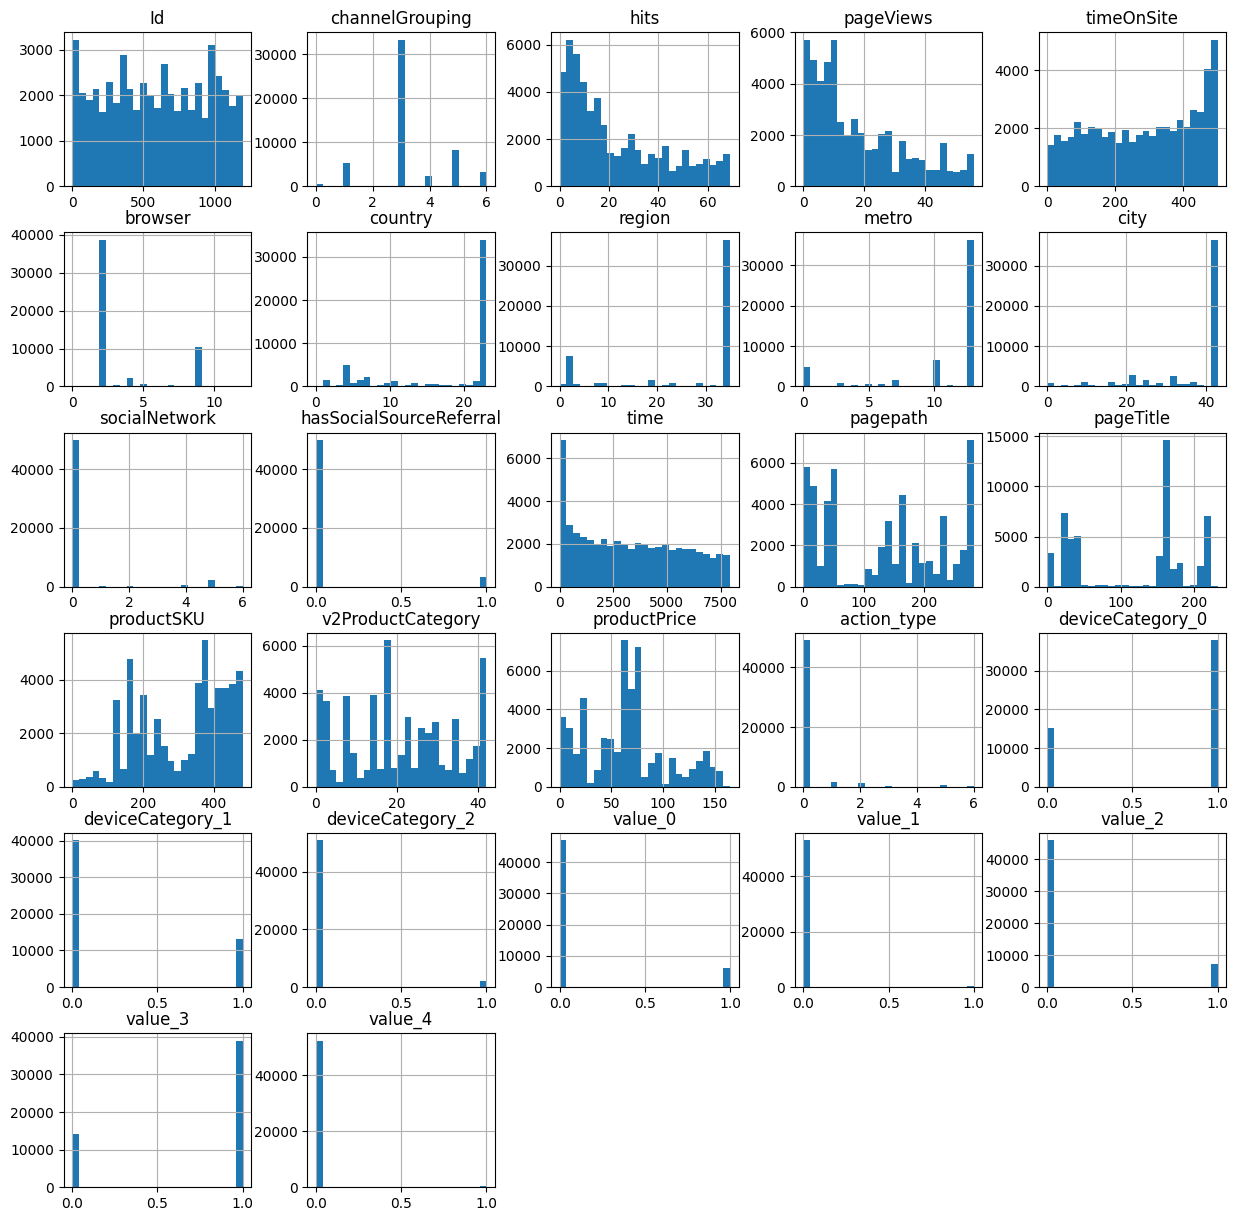

In [25]:
df1.hist(bins = 25, figsize = (15, 15))

In [26]:
num_cols = [col for col in df.columns if df[col].dtypes != "object"]
print(num_cols)

['Id', 'channelGrouping', 'hits', 'pageViews', 'timeOnSite', 'browser', 'country', 'region', 'metro', 'city', 'socialNetwork', 'hasSocialSourceReferral', 'time', 'pagepath', 'pageTitle', 'productSKU', 'v2ProductCategory', 'productPrice', 'action_type']


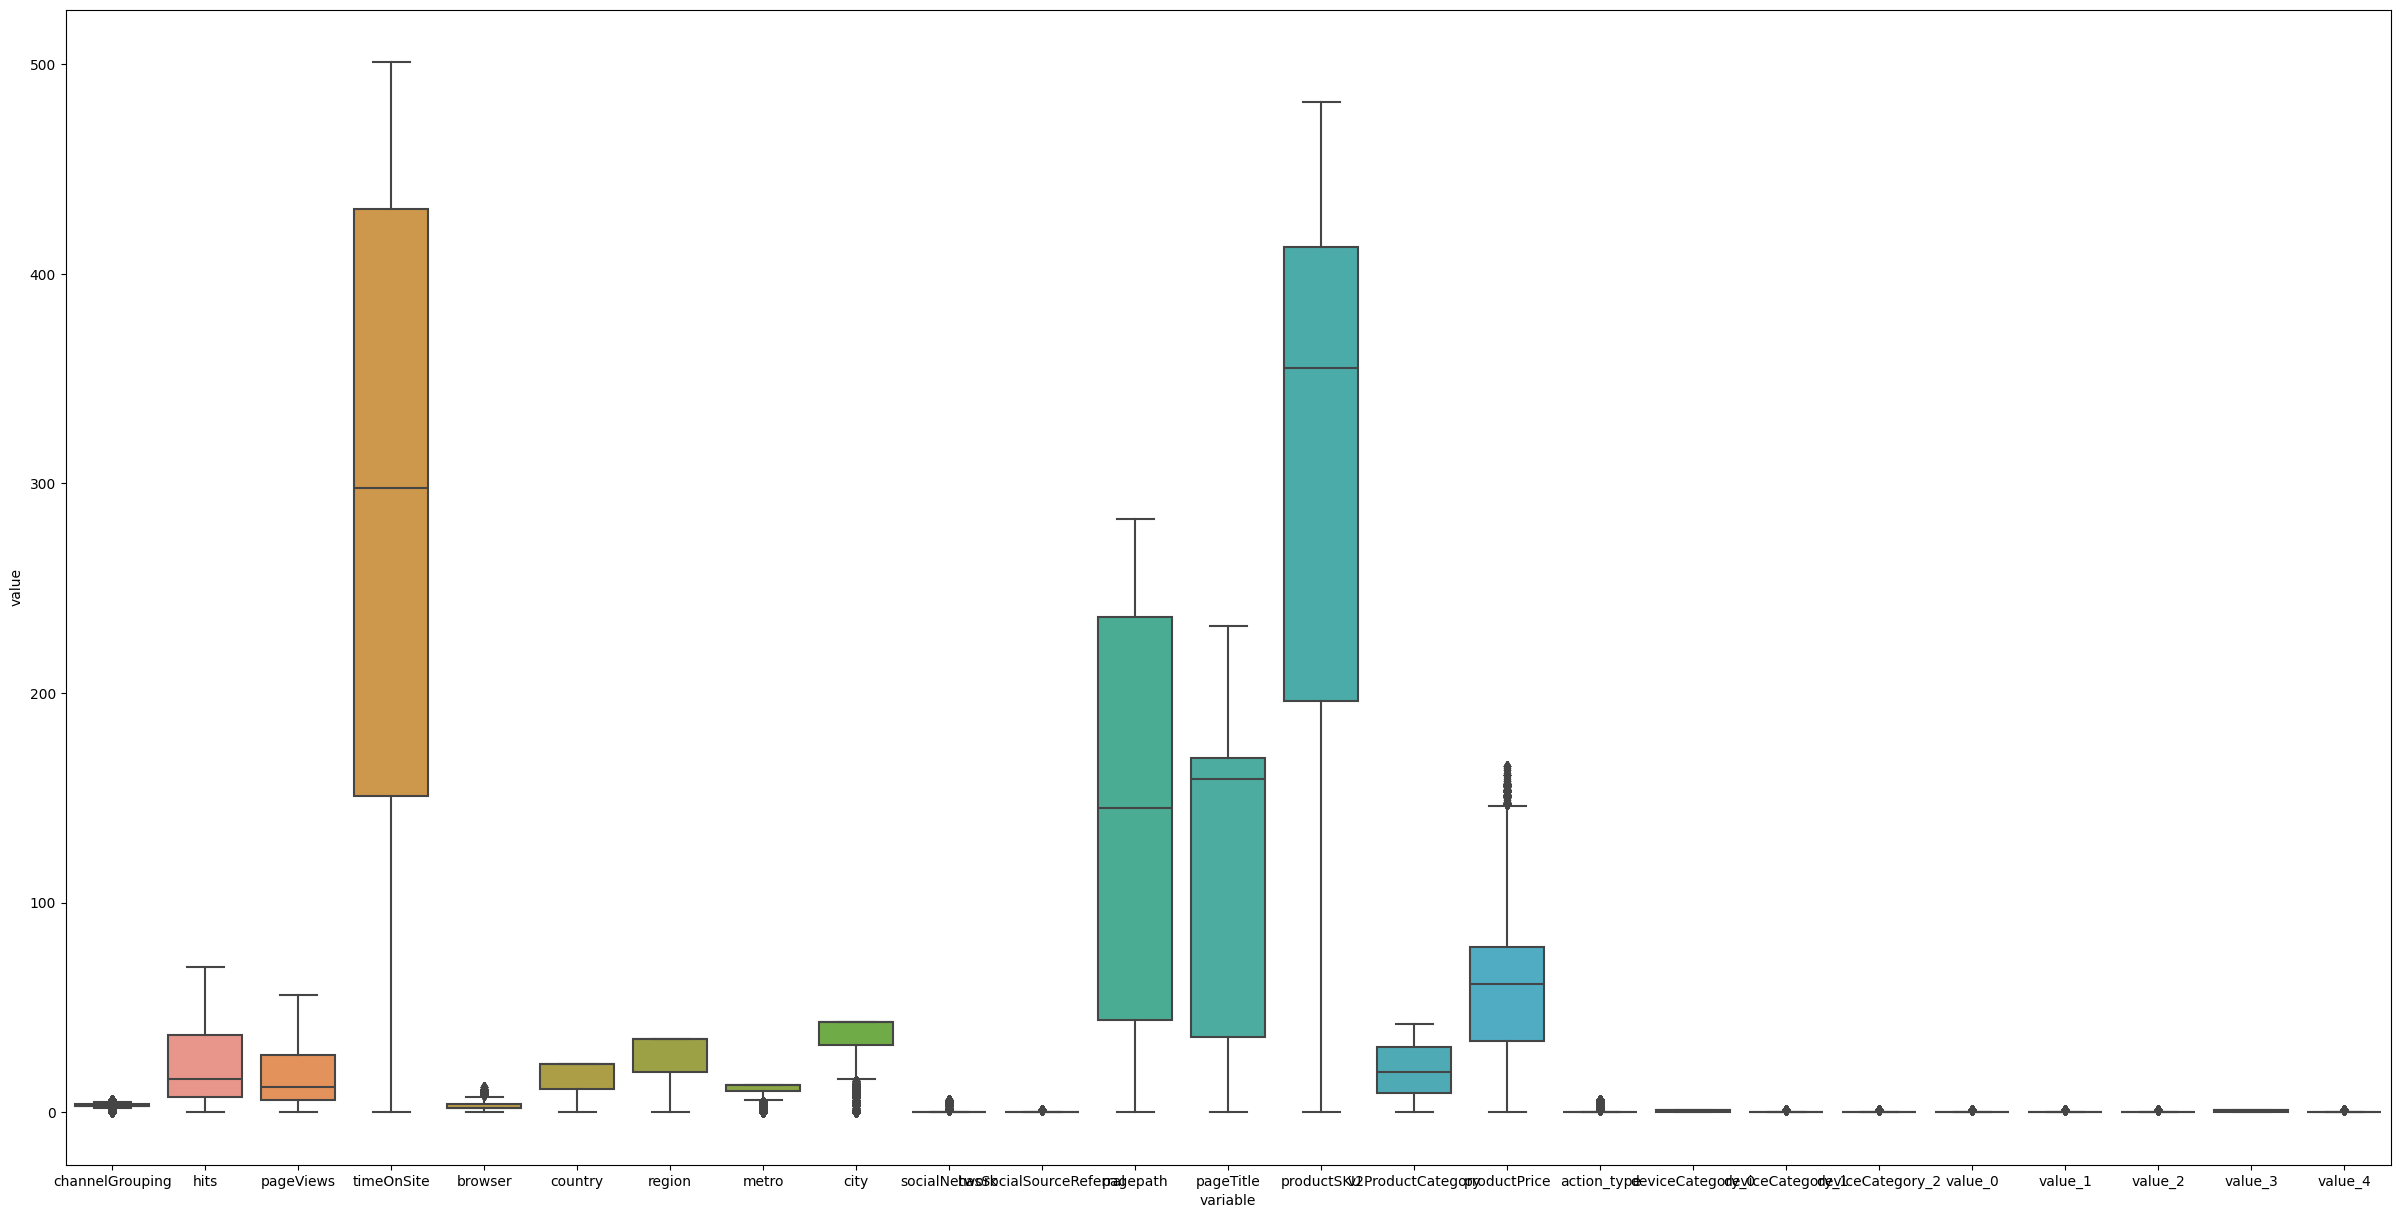

In [29]:
df2 = df1.drop(["Id","time"],axis=1)
# Create box plot for all the numerical features
plt.figure(figsize = (30,15))
sns.boxplot(x="variable", y="value",  data=pd.melt(df2))
plt.show()

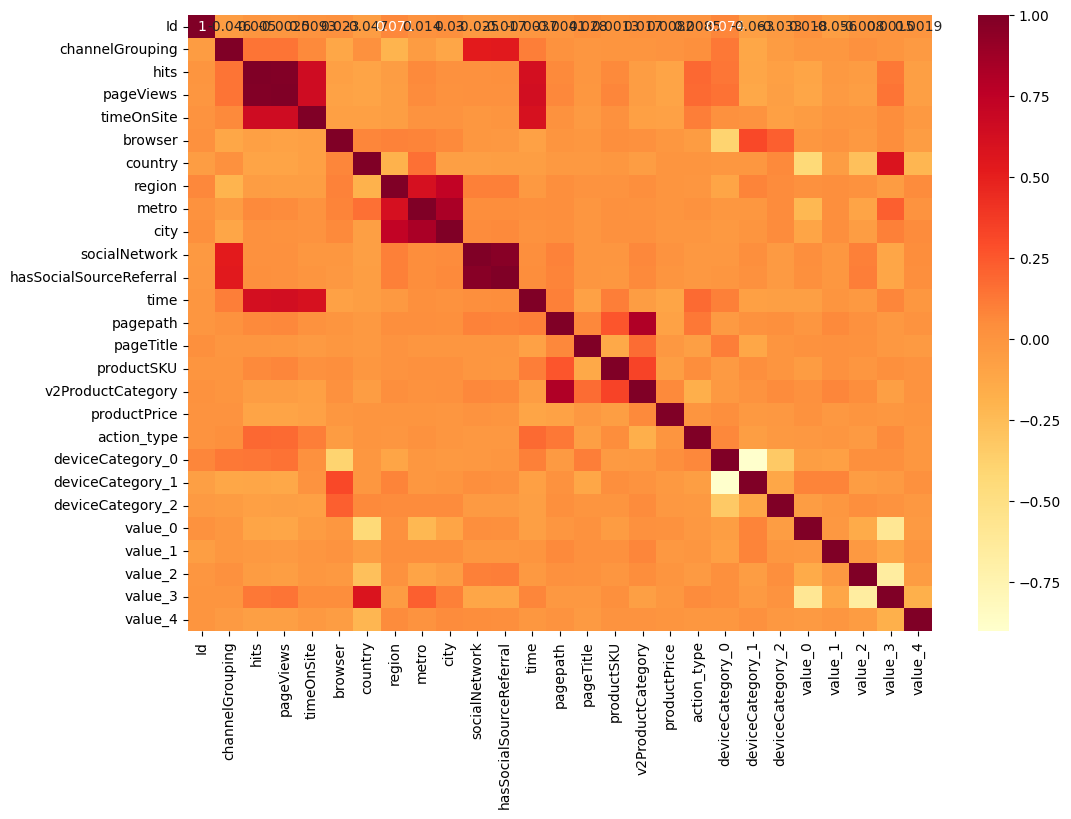

In [30]:
# EDA Multivariate analysis 
# Heatmap to see correlation between all numerical variables in the given dataset
plt.figure(figsize = (12,8))
corr_matrix = df1.corr()
sns.heatmap(corr_matrix, annot = True, cmap = "YlOrRd")
plt.show()

In [31]:
y = df1.action_type
X = df1.drop(["action_type"], axis = 1)
print(X.head())

    Id  channelGrouping  hits  pageViews  timeOnSite  browser  country  \
0  730                3     0          0         501        2       23   
1  730                3     0          0         501        2       23   
2  730                3     0          0         501        2       23   
3  730                3     0          0         501        2       23   
4  730                3     0          0         501        2       23   

   region  metro  city  ...  v2ProductCategory  productPrice  \
0      35     13    43  ...                 17            79   
1      35     13    43  ...                 17            79   
2      35     13    43  ...                 17            73   
3      35     13    43  ...                 17            79   
4      35     13    43  ...                 17            73   

   deviceCategory_0  deviceCategory_1  deviceCategory_2  value_0  value_1  \
0               0.0               1.0               0.0      0.0      0.0   
1               

In [32]:
# Find MI scores to see the relationship between input and output variables
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
print(mi_scores.sort_values(ascending = False))

pagepath                   0.207746
time                       0.129808
pageTitle                  0.101013
v2ProductCategory          0.067633
Id                         0.060532
timeOnSite                 0.058426
productSKU                 0.057733
hits                       0.041926
pageViews                  0.032865
productPrice               0.032114
country                    0.009194
metro                      0.007741
city                       0.007362
value_4                    0.007358
channelGrouping            0.006463
value_1                    0.003869
browser                    0.003594
deviceCategory_1           0.003229
value_2                    0.002979
socialNetwork              0.001539
hasSocialSourceReferral    0.000324
value_3                    0.000254
deviceCategory_2           0.000195
region                     0.000000
deviceCategory_0           0.000000
value_0                    0.000000
Name: MI Scores, dtype: float64


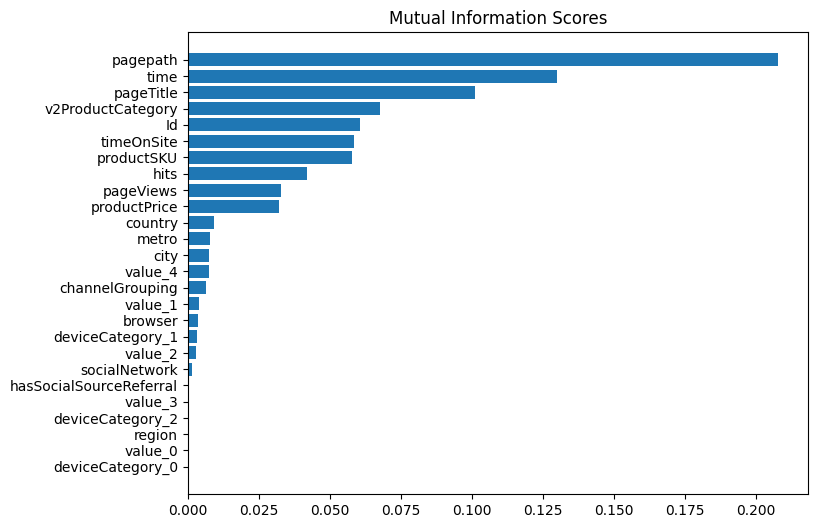

In [35]:
# Plot Mi scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 6))
plot_mi_scores(mi_scores)